In [1]:
#import libraries
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from kafka import KafkaConsumer
from json import dumps

In [2]:
#using the KafkaConsumer class from the Kafka Python library to consume messages from a Kafka topic named 'ml-raw-dns'
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

for m in consumer:
    break

In [3]:
#function to consume messages from a Kafka topic using a Kafka consumer (consumer) and retrieve the first 1000 records
def get_1000_rec(itr):
    list_of_1000_rec=[]
    i=0
    for c in consumer:

        if i <1000:
            list_of_1000_rec.append(c.value)
            i=i+1
        else:

            break
    print(f"Window {itr}")
    return list_of_1000_rec

In [4]:
#function to takes a list of data items as input, processes each item, and returns a pandas DataFrame.
def adjust_data( data):
    dataframe=pd.DataFrame()
    list_of_rows=[]
    for item in data:
        row_string=eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_rows.append(row)
    dataframe=pd.DataFrame(list_of_rows)
    dataframe.columns=col_names
    return dataframe

In [5]:
#function for cleaning the data steps same as the part 1
def cleaning_the_data(data):
    data['longest_word'] = data['longest_word'].replace(r'(([a-z]+)|([A-Z]+)|'')',2, regex=True)
    data['longest_word'].fillna(2,inplace=True)
    data['sld'] = data['sld'].replace(r'(([a-z]+)|([A-Z]+|(0-1)))',192, regex=True)
    data['sld']=data['sld'] .astype('int')
    data.drop('timestamp', inplace=True, axis=1)
    return data.astype('float')

In [6]:
#function performs a machine learning pipeline for feature selection and classification.
def retrain(data):
    pipe = Pipeline(steps=[("MI with LR",SelectKBest(score_func=mutual_info_classif, k=11)), ("LogisticRegression", LogisticRegression(max_iter=1000))])
    X =data.drop(labels = ["Target Attack"], axis=1)
    y=data["Target Attack"]
    pipe.fit(X,y)
    return pipe

In [7]:
#defined a list of column names, loading two machine learning models (static_model and Dynamic_model) from pickle files.
col_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
static_model = pickle.load(open('mutual_info_lr_model.pkl', 'rb'))
Dynamic_model= pickle.load(open('mutual_info_lr_model.pkl', 'rb'))

In [8]:
#iterating a loop
#processing new data in each iteration, 
#evaluating the performance of both a dynamic model (Dynamic_model) and a static model (static_model)
#retraining the dynamic model when its accuracy falls below a 81%

training_data=cleaning_the_data(adjust_data(get_1000_rec(0)))
list_of_f1_Dynmaic_model=[]
list_of_f1_static_model=[]

for itr in range(1,250):
    r_dataset = get_1000_rec(itr)
    p_dataset =  adjust_data(r_dataset)
    new_dataset =  cleaning_the_data(p_dataset)
    
    X =new_dataset.drop(labels = ["Target Attack"], axis=1)
    y=new_dataset["Target Attack"]
    
    Dy_pred=Dynamic_model.predict(X)
    D_acc=accuracy_score(y,Dy_pred)
    print(f"The accuracy of Dynamic Model without retrain = {D_acc*100}%")
    
    if D_acc < 0.81 :
        print(" trained model on the new data")
        Dynamic_model=retrain(training_data)
        Dy_pred=Dynamic_model.predict(X)
        D_acc=accuracy_score(y,Dy_pred)
        print(f"The accuracy of Dynamic Model after retrain = {D_acc*100}%")
        
    training_data=pd.concat([training_data,new_dataset])
    Sy_pred=static_model.predict(X)
    S_acc=accuracy_score(y,Sy_pred)
    print(f"The accuracy of Static Model = {S_acc*100}%")
    list_of_f1_Dynmaic_model.append(D_acc)
    list_of_f1_static_model.append(S_acc)
    print(f"{'*'*10}")

Window 0
Window 1
The accuracy of Dynamic Model without retrain = 81.39999999999999%
The accuracy of Static Model = 81.39999999999999%
**********
Window 2
The accuracy of Dynamic Model without retrain = 79.5%
 trained model on the new data
The accuracy of Dynamic Model after retrain = 79.60000000000001%
The accuracy of Static Model = 79.5%
**********
Window 3
The accuracy of Dynamic Model without retrain = 81.5%
The accuracy of Static Model = 81.5%
**********
Window 4
The accuracy of Dynamic Model without retrain = 80.4%
 trained model on the new data
The accuracy of Dynamic Model after retrain = 80.2%
The accuracy of Static Model = 80.4%
**********
Window 5
The accuracy of Dynamic Model without retrain = 80.7%
 trained model on the new data
The accuracy of Dynamic Model after retrain = 80.5%
The accuracy of Static Model = 80.80000000000001%
**********
Window 6
The accuracy of Dynamic Model without retrain = 80.5%
 trained model on the new data
The accuracy of Dynamic Model after retra

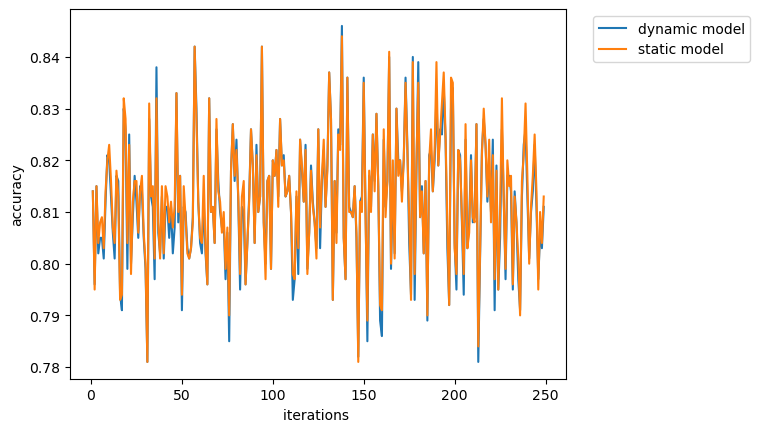

In [10]:
#plot the accuracy scores of the dynamic and static models over the iterations.
plt.plot(range(1, 250), list_of_f1_Dynmaic_model, label=f'dynamic model')
plt.plot(range(1, 250),list_of_f1_static_model, label=f'static model')
plt.xlabel('iterations ')
plt.ylabel("accuracy")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")